In [18]:
# %load plot_template.py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

plt.rc('font', family='serif')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10, color='grey')
plt.rc('ytick', labelsize=10, color='grey')
plt.rc('legend', fontsize=12, loc='lower left')
plt.rc('figure', titlesize=12)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [19]:
import utlis
from sklearn.metrics import mean_absolute_error, mean_squared_error

import lightgbm as lgb

In [20]:
## Replace PATH_TO_ROOT

import sys
PATH_TO_ROOT = '/Users/guanyuxiaoxiong/City-Scale-Electricity-Use-Prediction-master'
sys.path.insert(0,PATH_TO_ROOT)

In [25]:
def generate_fig_path(fig_name):
    '''
    Generate the figure path and name
    To be used by plt.savefig function
    '''
    return '{}/results/fig/section3.4 tabular data model/{}'.format(PATH_TO_ROOT, fig_name)

def generate_input_data_path(data_name):
    '''
    Generate the path to input data
    '''
    return '{}/results/data/{}.csv'.format(PATH_TO_ROOT, data_name)

def generate_result_data_path(data_name):
    '''
    Generate the path to save the result data
    '''
    return '{}/results/data/predict/{}.csv'.format(PATH_TO_ROOT, data_name)

In [39]:
def lightGBM_train(region, params):
    
    # read the data
    data = pd.read_csv(generate_input_data_path(f'{region}_daily'), index_col=0,  parse_dates=True)
    data.index = pd.to_datetime(data.index)
    data = data.truncate(after='2019-07-01')  # do not use the last year to avoid the influence of COVID
    data_lgmb = data[['Temperature, daily mean (degC)', 'Temperature, daily peak (degC)', 'Holiday', 'Weekend',
                      'Electricity demand, daily sum, (GWh)']]

       # feature engineering
    data_lgmb['Month'] = data_lgmb.index.month
    data_lgmb['dayOfWeek'] = data_lgmb.index.weekday
    data_lgmb = data_lgmb.dropna()
    # train_test split
    data_train, data_test = utlis.prepare_data(data_lgmb, train_ratio=0.75)
    X_train = data_train[['Temperature, daily mean (degC)', 'Temperature, daily peak (degC)', 
                          'Holiday', 'dayOfWeek', 'Month']].values
    X_test = data_test[['Temperature, daily mean (degC)', 'Temperature, daily peak (degC)', 
                        'Holiday', 'dayOfWeek', 'Month']].values
    y_train = data_train['Electricity demand, daily sum, (GWh)'].values
    y_test = data_test['Electricity demand, daily sum, (GWh)'].values
    X_all = data_lgmb[['Temperature, daily mean (degC)', 'Temperature, daily peak (degC)', 
                       'Holiday', 'dayOfWeek', 'Month']].values
    
    d_train = lgb.Dataset(X_train, categorical_feature=[2,3,4], label=y_train)

    # train and print the errors
    regr = lgb.train(params, d_train, 5000)
    
    rmse_train = mean_squared_error(regr.predict(X_train), y_train)**0.5
    rmse_test = mean_squared_error(regr.predict(X_test), y_test)**0.5
    print(f'-------City: {region}--------------')
    print(f'RMSE for Train: {rmse_train}')
    print(f'RMSE for Test: {rmse_test}')
    
    # make prediction on the whole data set and save the results for model comparison
    data_lgmb['yhat_lgbm'] = regr.predict(X_all)
    data_lgmb.index = data_lgmb['ds']
    data_lgmb.to_csv(generate_result_data_path(f'lgbm_{region}'), index=False)
    
    # Overwrite previous output result
    result_path = generate_result_data_path(f'lgbm_{region}')
    if os.path.exists(result_path):
        os.remove(result_path)  # delete old result file if it exists
    data_lgmb.to_csv(result_path, index=False)
    
    # prepare the data for plotting
    verif_plot = data_lgmb[['Electricity demand, daily sum, (GWh)','yhat_lgbm']]
    verif_plot.rename(columns={'Electricity demand, daily sum, (GWh)':'y',
                               'yhat_lgbm':'yhat'}, inplace=True)
    verif_plot['train'] = False
    verif_plot.loc[data_train.ds, 'train'] = True
    
    return verif_plot

In [40]:
# set up the hyper-parameter
params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mse'
# params['sub_feature'] = 0.5
params['num_leaves'] = 4
params['min_data_in_leaf'] = 30
params['max_depth'] = 5

In [41]:
la_lgbm = lightGBM_train('la', params)
sac_lgbm = lightGBM_train('sac', params)
ny_lgbm = lightGBM_train('ny', params)

/var/folders/pl/92s029gs4d7cvy8d6gbcy6m00000gn/T/ipykernel_56626/1493567446.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lgmb['Month'] = data_lgmb.index.month
/var/folders/pl/92s029gs4d7cvy8d6gbcy6m00000gn/T/ipykernel_56626/1493567446.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lgmb['dayOfWeek'] = data_lgmb.index.weekday
/Users/guanyuxiaoxiong/opt/anaconda3/envs/cityEleEnv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 5
[LightGBM] [Info] Start training from score 78.360358
-------City: la--------------
RMSE for Train: 2.6784911958846975
RMSE for Test: 5.061207183153597


/var/folders/pl/92s029gs4d7cvy8d6gbcy6m00000gn/T/ipykernel_56626/1493567446.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot.rename(columns={'Electricity demand, daily sum, (GWh)':'y',
/var/folders/pl/92s029gs4d7cvy8d6gbcy6m00000gn/T/ipykernel_56626/1493567446.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot['train'] = False
/var/folders/pl/92s029gs4d7cvy8d6gbcy6m00000gn/T/ipykernel_56626/1493567446.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 5
[LightGBM] [Info] Start training from score 48.265634
-------City: sac--------------
RMSE for Train: 2.0280568819425993
RMSE for Test: 2.2058061419284933


/var/folders/pl/92s029gs4d7cvy8d6gbcy6m00000gn/T/ipykernel_56626/1493567446.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot.rename(columns={'Electricity demand, daily sum, (GWh)':'y',
/var/folders/pl/92s029gs4d7cvy8d6gbcy6m00000gn/T/ipykernel_56626/1493567446.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot['train'] = False
/var/folders/pl/92s029gs4d7cvy8d6gbcy6m00000gn/T/ipykernel_56626/1493567446.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 5
[LightGBM] [Info] Start training from score 434.350071
-------City: ny--------------
RMSE for Train: 13.608847087024015
RMSE for Test: 17.845175539204117


/var/folders/pl/92s029gs4d7cvy8d6gbcy6m00000gn/T/ipykernel_56626/1493567446.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot.rename(columns={'Electricity demand, daily sum, (GWh)':'y',
/var/folders/pl/92s029gs4d7cvy8d6gbcy6m00000gn/T/ipykernel_56626/1493567446.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot['train'] = False


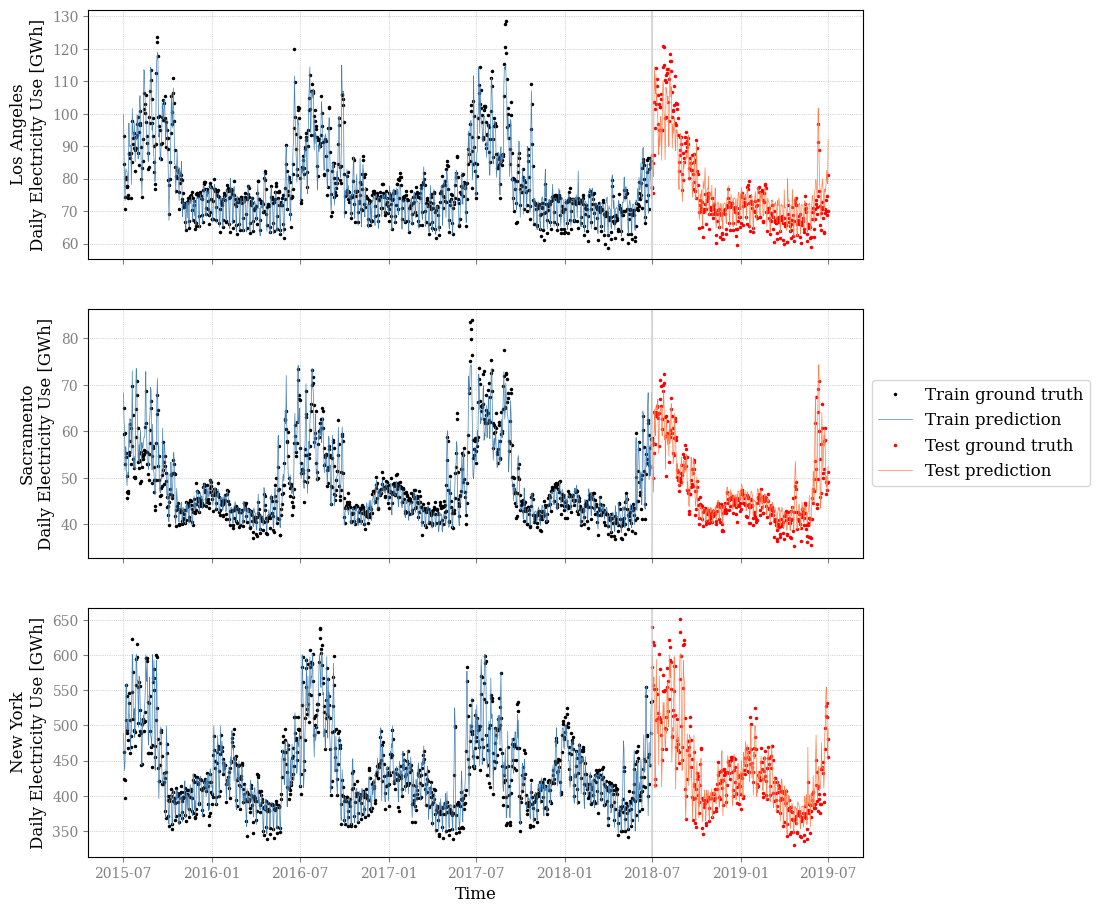

In [42]:
data_all = [la_lgbm, sac_lgbm, ny_lgbm]
cities = ['Los Angeles', 'Sacramento', 'New York']

fig, axes = plt.subplots(3, 1, figsize=(10, 11), sharex=True)

for index in range(3):
    data = data_all[index]
    city = cities[index]
    
    train = data[data['train']]
    axes[index].plot(train.index, train.y, 'ko', markersize=1.5, label='Train ground truth')
    axes[index].plot(train.index, train.yhat, color='steelblue', lw=0.5, label='Train prediction')
    test = data[data['train'] == False]
    axes[index].plot(test.index, test.y, 'ro', markersize=1.5, label='Test ground truth')
    axes[index].plot(test.index, test.yhat, color='coral', lw=0.5, label='Test prediction')

    axes[index].axvline(data[data['train']].index[-1], color='0.8', alpha=0.7)
    axes[index].set_ylabel(f'{city}\nDaily Electricity Use [GWh]')
    axes[index].grid(ls=':', lw=0.5)

axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[2].set_xlabel('Time')

plt.savefig(generate_fig_path('Figure 14'))